In [859]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [1752]:
def enhance_fringes_contrast(img, boost_factor=2.0, mask_radius=20, filter_radius=15):
    fft = np.fft.fftshift(np.fft.fft2(img))
    h, w = img.shape
    cy, cx = h//2, w//2

    Y, X = np.ogrid[:h, :w]
    center_mask = (X-cx)**2 + (Y-cy)**2 <= mask_radius**2
    spectrum = np.abs(fft)
    spectrum_masked = spectrum.copy()
    spectrum_masked[center_mask] = 0

    max_y, max_x = np.unravel_index(np.argmax(spectrum_masked), spectrum_masked.shape)

    pos_mask = (Y - max_y)**2 + (X - max_x)**2 < filter_radius**2
    fft[pos_mask] *= boost_factor

    enhanced_img = np.abs(np.fft.ifft2(np.fft.ifftshift(fft)))

    return enhanced_img

In [1754]:
def mask_center(img, radius = 10, rotation90 = 0):
    h, w = np.rot90(img, rotation90).shape
    cy, cx = h//2, w//2
    mask_radius = 15
    Y, X = np.ogrid[:h, :w]
    mask = ((X-cx)**2 + (Y-cy)**2 <= mask_radius**2) | ~((X >= cx) & (Y <= cy))
    mask = np.rot90(mask, rotation90)
    img_masked = img.copy()
    img_masked[mask] = 0
    return img_masked

In [1756]:
def find_plus_one_order_position(img, mask_radius=15, rotation90 = 0):
    h, w = img.shape
    cy, cx = h//2, w//2
    spectrum_img = img.copy()
    spectrum_masked = mask_center(spectrum_img, rotation90=rotation90)
    f_y, f_x = np.unravel_index(np.argmax(spectrum_masked), spectrum_masked.shape)
    return f_x, f_y

In [1758]:
def get_spectrum_image_from_fft(fft):
    return np.log(1 + np.abs(fft))
    

In [1760]:
def filter_spectrum(fft, f_x, f_y, radius=20):
    h, w = fft.shape
    cy, cx = h//2, w//2

    filter_mask = np.zeros((h, w), dtype=bool)
    Y, X = np.ogrid[:h, :w]
    dist_sq = (Y - f_y)**2 + (X - f_x)**2
    filter_mask = dist_sq < radius**2
    fft_filtered = np.zeros_like(fft)
    fft_filtered[filter_mask] = fft[filter_mask]
    return fft_filtered

In [1762]:
def center_spectrum(fft, f_x, f_y):
    h, w = fft.shape
    c_y, c_x = h//2, w//2
    spectrum_centred = np.roll(fft, -int(f_y - c_y), axis=0)
    spectrum_centred = np.roll(spectrum_centred, -int(f_x - c_x), axis=1)
    return spectrum_centred
    

In [1764]:
img3 = cv2.imread(r"Images\Image 3\Blood Cells 3.bmp", cv2.IMREAD_GRAYSCALE)

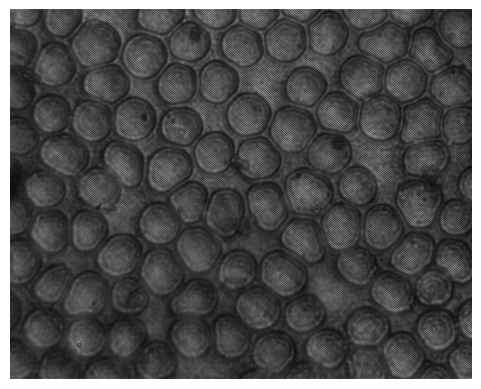

In [1768]:
plt.imshow(img3, cmap='gray')
plt.axis('off')
plt.show()

In [1770]:
enhanced_img = enhance_fringes_contrast(img3, boost_factor=5,  filter_radius = 75)

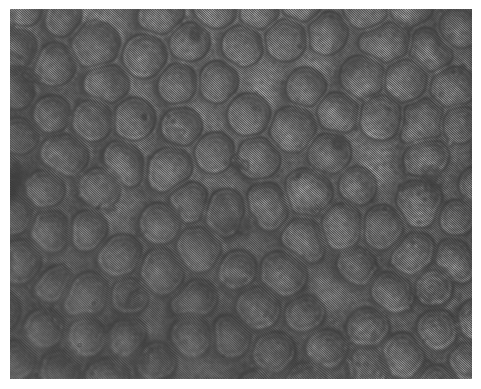

In [1772]:
plt.imshow(enhanced_img, cmap='gray')
plt.axis('off')
plt.show()

In [1774]:
fft = np.fft.fftshift(np.fft.fft2(enhanced_img))
spectrum = np.log(1 + np.abs(fft))
f_x, f_y = find_plus_one_order_position(spectrum, mask_radius = 10)
filtered_spectrum = filter_spectrum(fft, f_x, f_y, radius=75)
centered_spectrum = center_spectrum(filtered_spectrum, f_x, f_y)
amplitude = np.fft.ifft2(np.fft.ifftshift(centered_spectrum))

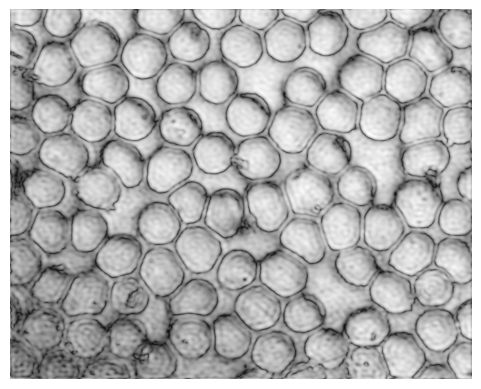

In [1776]:
plt.imshow(get_spectrum_image_from_fft(amplitude), cmap='gray')
plt.axis('off')
plt.show()

In [1778]:
normalized = cv2.normalize(get_spectrum_image_from_fft(amplitude), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

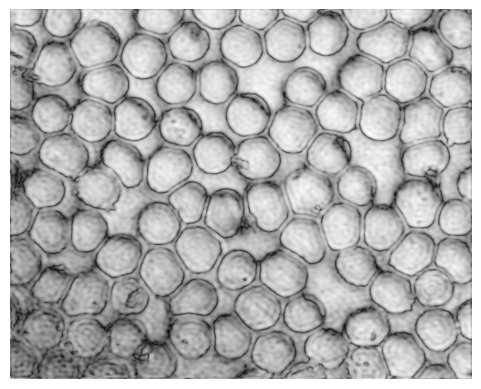

In [1780]:
plt.imshow(normalized, cmap='gray')
plt.axis('off')
plt.show()

In [1782]:
blurM = cv2.medianBlur(normalized, 5)

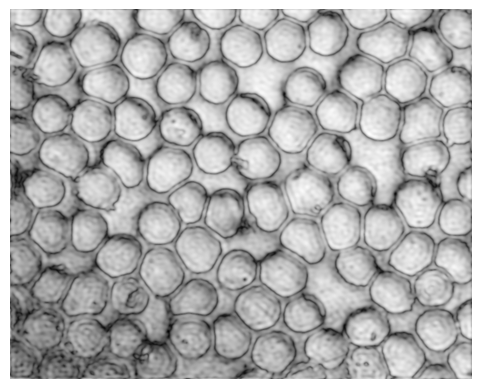

In [1784]:
plt.imshow(blurM, cmap='gray')
plt.axis('off')
plt.show()

In [1786]:
def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1) * pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1) / (r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2) / (255 - r2)) * (pix - r2) + s2

    # Define parameters. 


r1 = 70
s1 = 0
r2 = 200
s2 = 255

# Vectorize the function to apply it to each value in the Numpy array. 
pixelVal_vec = np.vectorize(pixelVal)

In [1788]:
contrast_stretched = pixelVal_vec(blurM, r1, s1, r2, s2).astype(np.uint8)

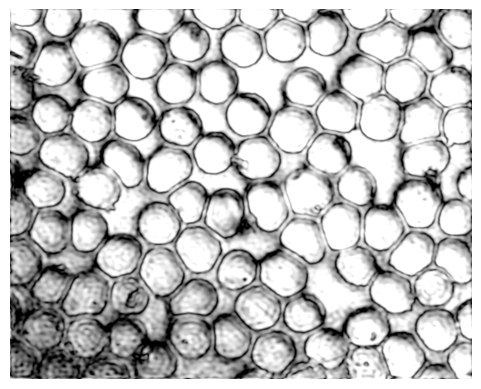

In [1789]:
plt.imshow(contrast_stretched, cmap='gray')
plt.axis('off')
plt.show()

In [1792]:
edge = cv2.Canny(contrast_stretched, 100, 200)

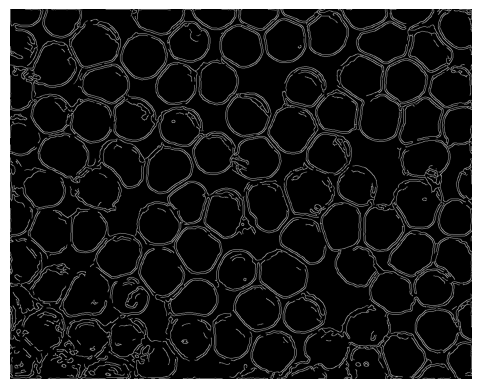

In [1794]:
plt.imshow(edge, cmap='gray')
plt.axis('off')
plt.show()

In [1796]:
kernel = np.ones((2, 2), np.uint8)
dilation = cv2.dilate(edge, kernel, iterations = 10)
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)

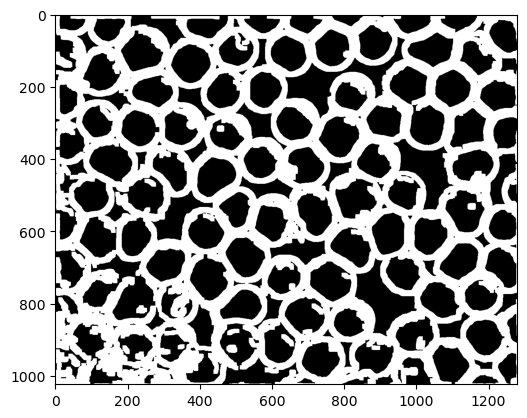

In [1798]:
plt.imshow(closing, cmap='gray')

In [1800]:
cv2.imwrite('contours.png', closing)

True

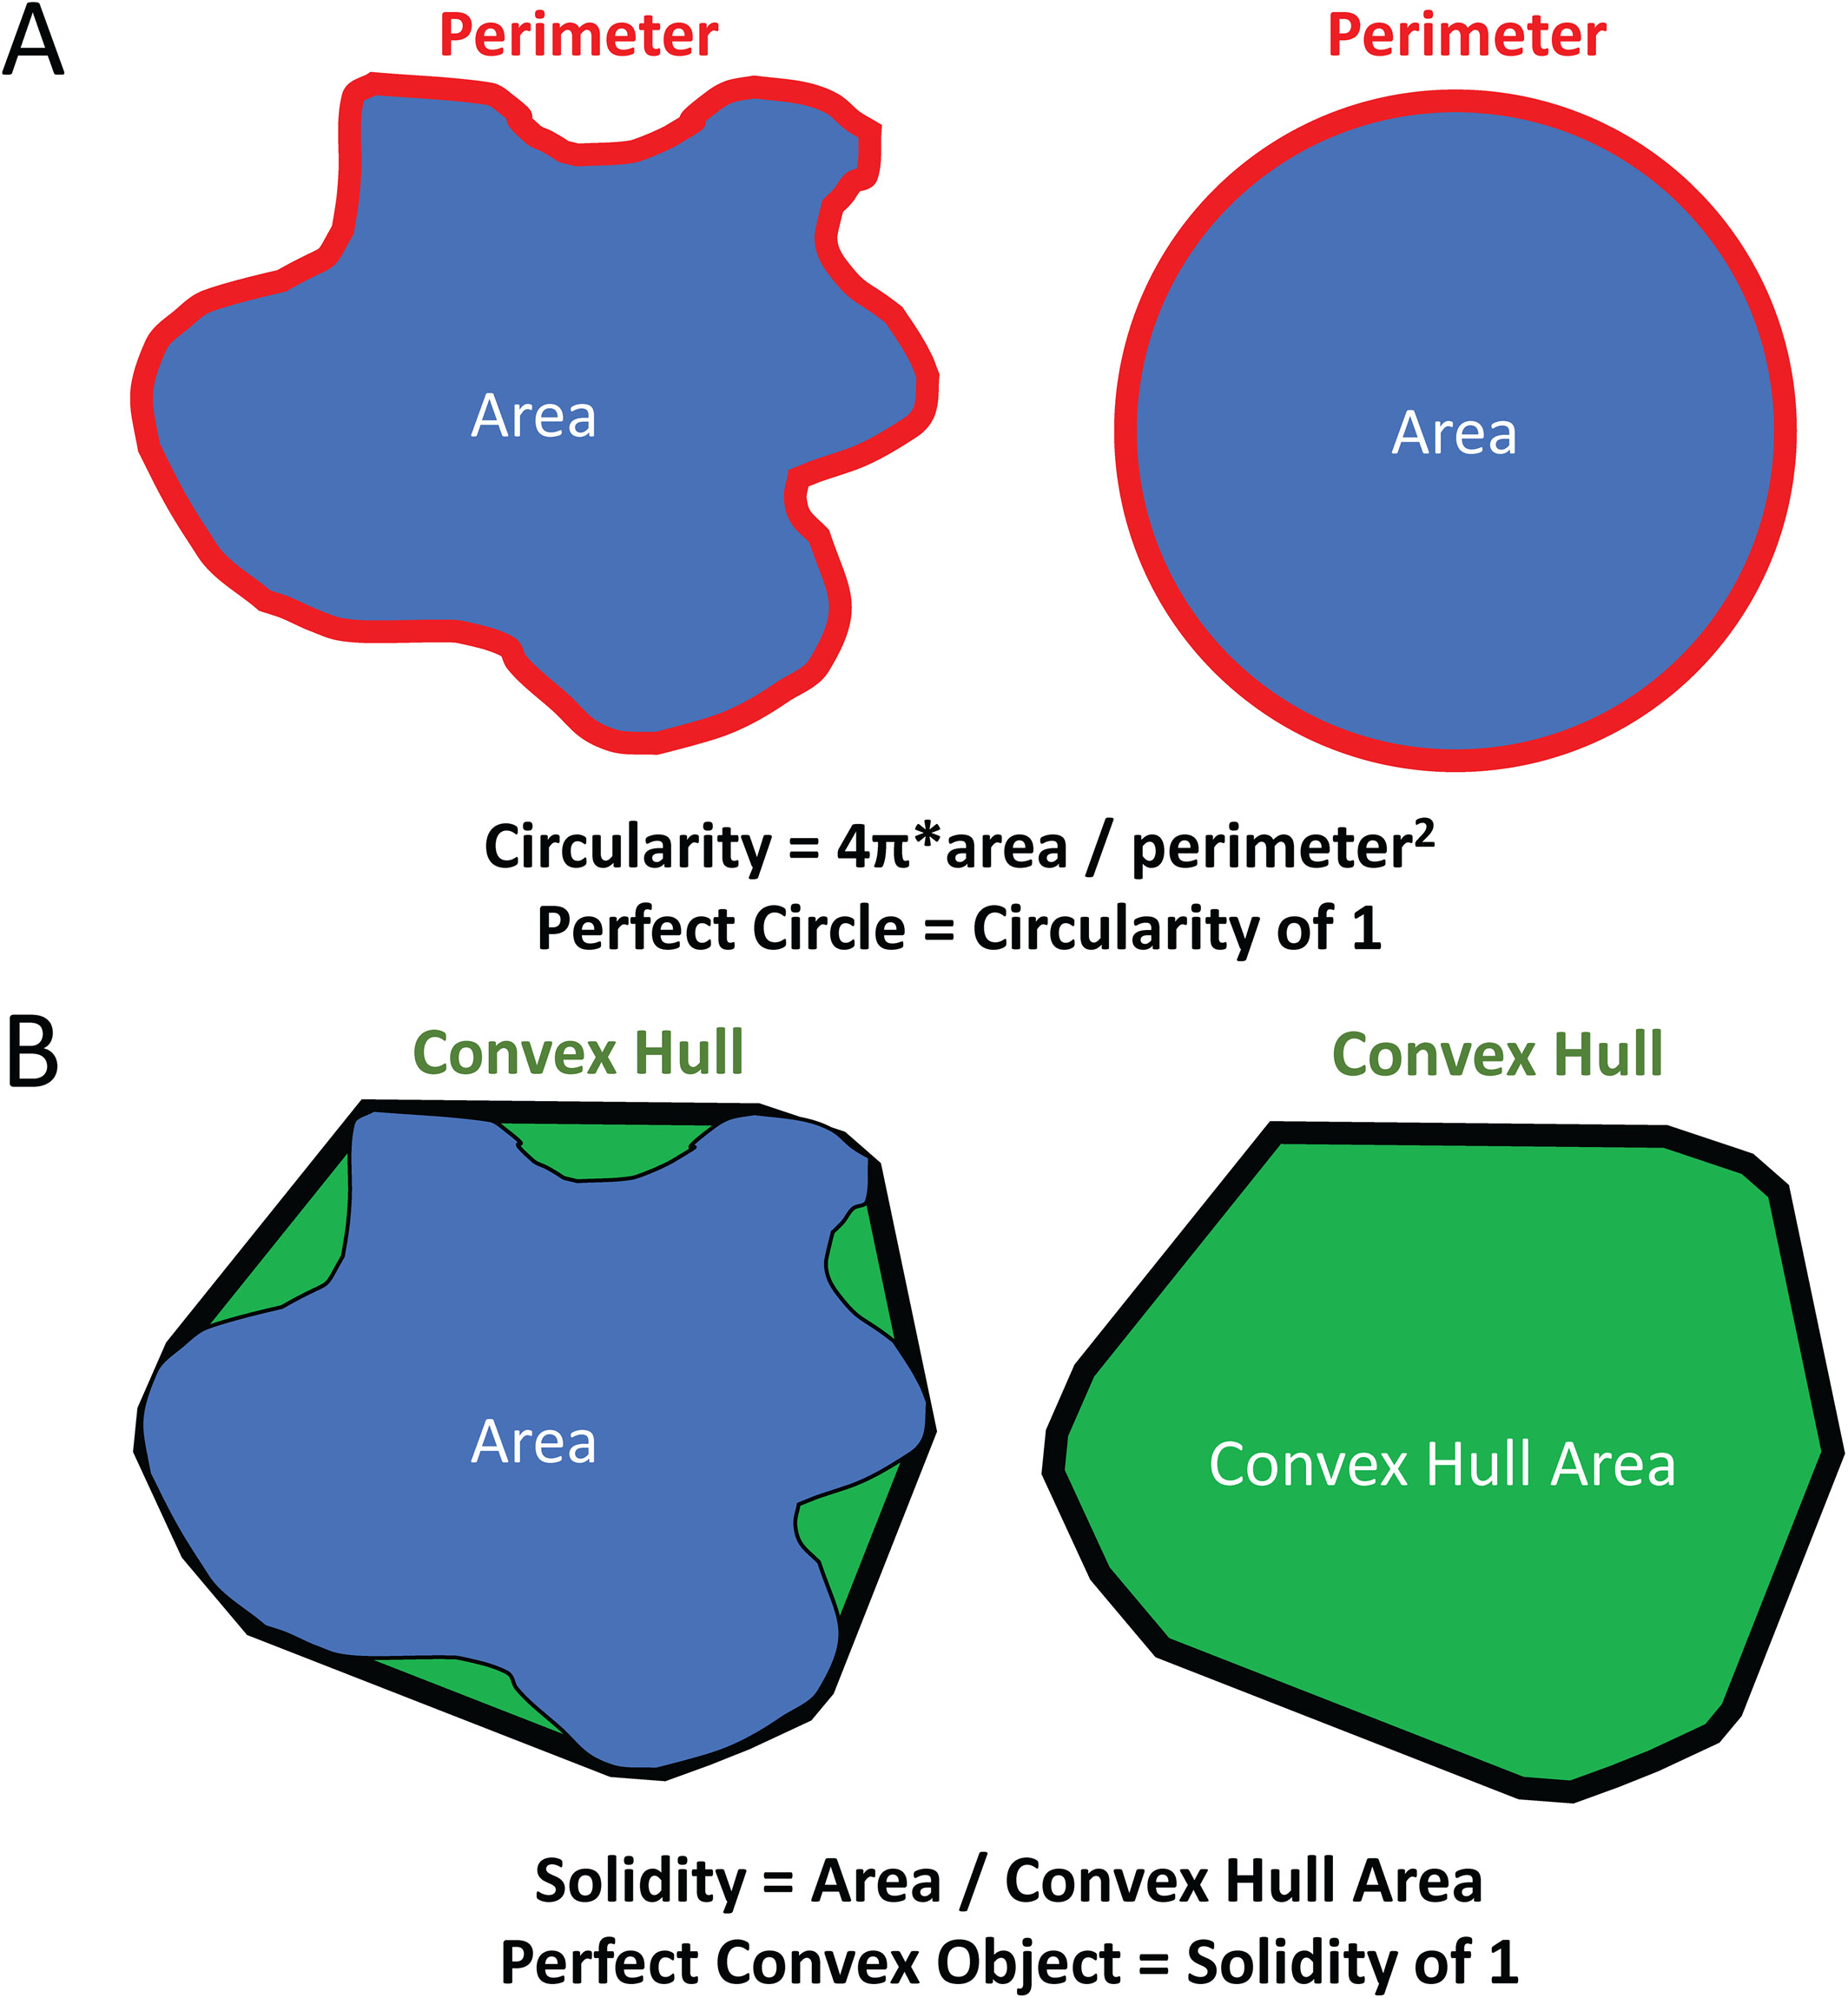

In [2010]:
def detect_erythrocytes(contour_image_path, original_image_path, padding=20, 
                             circularity_threshold = 0.5, solidity_threshold = 0.7, eccentricity_threshold = 0.9):

    contour_img = cv2.imread(contour_image_path, cv2.IMREAD_GRAYSCALE)
    original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)

    inverted = cv2.bitwise_not(contour_img)
    _, binary = cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    result = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    erythrocytes = []
    cell_images = []
    h, w = contour_img.shape
    
    erythrocytes_count = 0
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        
        if area < 500 or area > 10000:
            continue
            
        left = stats[i, cv2.CC_STAT_LEFT]
        top = stats[i, cv2.CC_STAT_TOP]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        
        if (left <= padding or top <= padding or left + width >= w-padding or top + height >= h-padding):
            continue
            
        mask = (labels == i).astype(np.uint8) * 255
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            contour = contours[0]
            
            # Периметр и площадь
            perimeter = cv2.arcLength(contour, True)
            area_contour = cv2.contourArea(contour)
            
            if perimeter > 0:
                circularity = 4 * np.pi * area_contour / (perimeter * perimeter)
            else:
                circularity = 0
            
            epsilon = 0.02 * perimeter
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = area_contour / hull_area if hull_area > 0 else 0
            
            if len(contour) >= 5:
                ellipse = cv2.fitEllipse(contour)
                (center, axes, orientation) = ellipse
                major_axis = max(axes)
                minor_axis = min(axes)
                eccentricity = np.sqrt(1 - (minor_axis/major_axis)**2) if major_axis > 0 else 0
            else:
                eccentricity = 1
            
            if circularity > circularity_threshold and solidity > 0.7 and eccentricity < 0.9:
                erythrocytes_count += 1
            
                center_x = left + width // 2
                center_y = top + height // 2
                
                square_size = max(width, height) + 2 * padding
                
                crop_left = max(0, center_x - square_size // 2)
                crop_top = max(0, center_y - square_size // 2)
                crop_right = min(w, crop_left + square_size)
                crop_bottom = min(h, crop_top + square_size)
                
                if crop_right - crop_left < square_size:
                    crop_left = max(0, crop_right - square_size)
                if crop_bottom - crop_top < square_size:
                    crop_top = max(0, crop_bottom - square_size)
                
                cell_img = original_img[crop_top:crop_bottom, crop_left:crop_right]
                
                if cell_img.shape[0] != cell_img.shape[1]:
                    size = max(cell_img.shape)
                    square_cell = np.zeros((size, size), dtype=np.uint8)
                    y_offset = (size - cell_img.shape[0]) // 2
                    x_offset = (size - cell_img.shape[1]) // 2
                    square_cell[y_offset:y_offset + cell_img.shape[0], 
                               x_offset:x_offset + cell_img.shape[1]] = cell_img
                    cell_img = square_cell
                
                cell_info = {
                    'id': erythrocytes_count,
                    'area': area,
                    'circularity': circularity,
                    'solidity': solidity,
                    'eccentricity': eccentricity,
                    'centroid': (int(centroids[i][0]), int(centroids[i][1])),
                    'bbox': (left, top, width, height),
                    'crop_coords': (crop_left, crop_top, crop_right, crop_bottom)
                }
                
                erythrocytes.append(cell_info)
                cell_images.append(cell_img)
                
                color = (0, 255, 0) 
                
                cv2.rectangle(result, (left, top), (left+width, top+height), color, 2)
                cv2.putText(result, f"E{erythrocytes_count}", (int(centroids[i][0]), int(centroids[i][1])), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    
    print(f"{len(erythrocytes)} erythrocytes detected")
    
    return result, erythrocytes, cell_images

In [2012]:
result, erythrocytes, cell_images = detect_erythrocytes('contours.png', r"Images\Image 3\Blood Cells 3.bmp", padding = 25)

56 erythrocytes detected


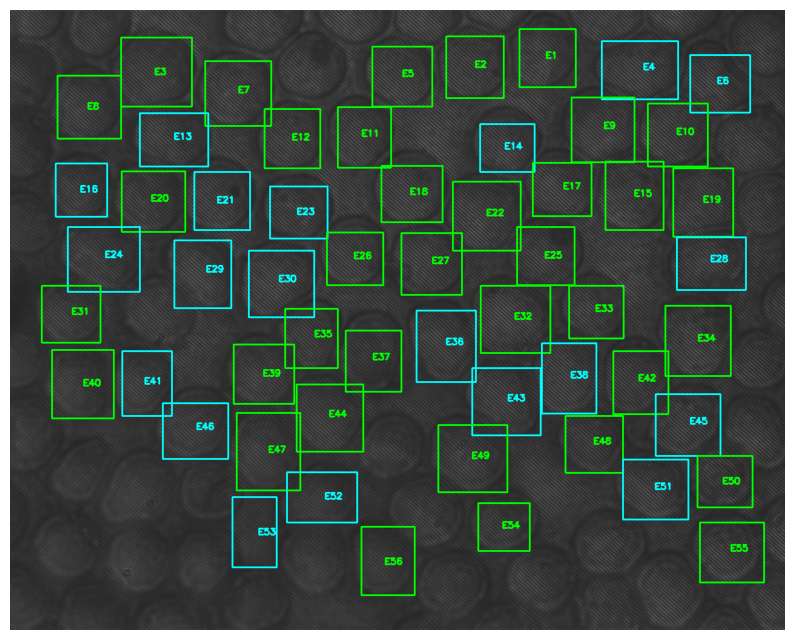

In [2014]:
plt.figure(figsize=(10, 10))
plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()

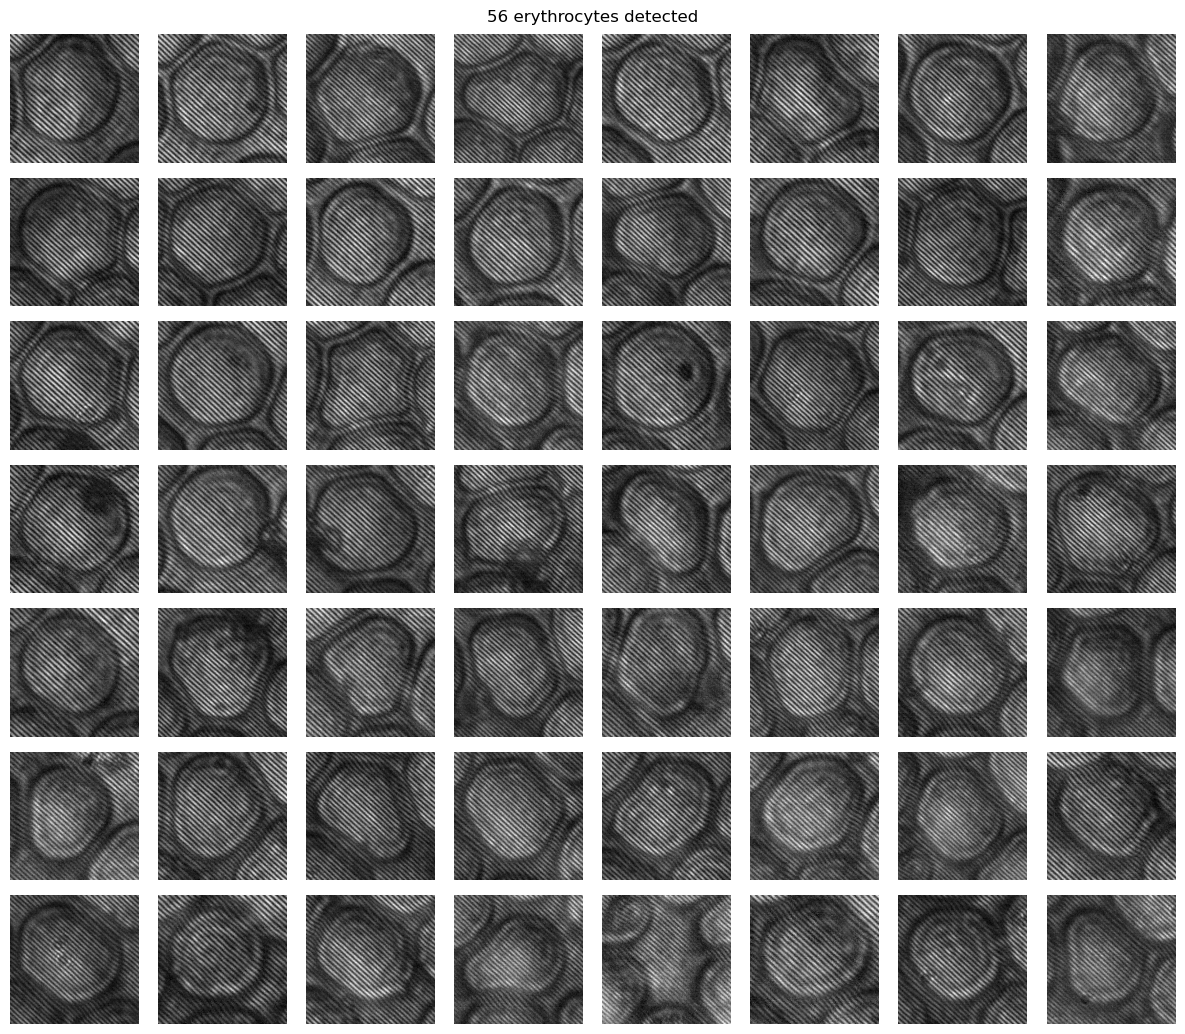

In [2016]:
import matplotlib.pyplot as plt
import math

n = len(cell_images)

cols = math.ceil(math.sqrt(n))
cols = max(2, min(cols, 8))

rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
axes = axes.flatten() if rows > 1 or cols > 1 else [axes]

for i in range(n):
    axes[i].imshow(cell_images[i], cmap='gray')
    axes[i].axis('off')

for i in range(n, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'{n} erythrocytes detected')
plt.tight_layout()
plt.show()